In [1]:
%matplotlib inline

In [23]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('poster')

import ipywidgets as widgets
import CatAna

# Basic Types

- Object: Stores position of a particle  
- ObjectContainer: Contains multiple Objects  
- PixelizedObjectContainer: HEALPix-like map, each pixel contains radii of contained particles  

In [3]:
help(CatAna.basictypes)

Help on module CatAna.basictypes in CatAna:

NAME
    CatAna.basictypes - python bindings of basic types used in CatAna

FILE
    /Users/michael/.python-eggs/CatAna-0.0-py2.7-macosx-10.11-x86_64.egg-tmp/CatAna/basictypes.so

CLASSES
    __builtin__.object
        EigenArrayXXcd
        EigenArrayXXd
        EigenArrayXd
        EigenArrayXi
        FunctionInterpolator
        Object
        ObjectContainer
        PixelizedObjectContainer
    
    class EigenArrayXXcd(__builtin__.object)
     |  Methods defined here:
     |  
     |  __init__(...)
     |      x.__init__(...) initializes x; see help(type(x)) for signature
     |  
     |  ----------------------------------------------------------------------
     |  Data and other attributes defined here:
     |  
     |  __new__ = <built-in method __new__ of type object>
     |      T.__new__(S, ...) -> a new object with type S, a subtype of T
    
    class EigenArrayXXd(__builtin__.object)
     |  Methods defined here:
     |  
    

## Objects and ObjectContainers

In [4]:
# Some random particle positions in a 200x200x200 box
python_particles = np.random.uniform(-100,100,(100000,3))
print python_particles[0]

[ 35.52186684 -49.80164133  94.94618743]


In [5]:
# Load into ObjectContainer
object_container = CatAna.ObjectContainer(python_particles, 'cartesian')

In [6]:
# Retreive numpy array (now spherical coordinates)
python_particles_from_oc = np.array(object_container)
print python_particles_from_oc[0]

[ 112.94593844    0.57234371    5.33196358]


In [7]:
# Can also construct ObjectContainer from spherical coordinates
object_container_2 = CatAna.ObjectContainer(python_particles_from_oc, 'spherical')

In [8]:
# Retreive Object:
obj = object_container[0]
print np.array(obj)
print obj.cartesian()

[ 112.94593844    0.57234371    5.33196358]
(35.52186684474812, -49.8016413275625, 94.94618743044855)


## PixelizedObjectContainers

In [9]:
# Create from NSide and ObjectContainer
pixelized_object_container = CatAna.PixelizedObjectContainer(64, object_container)

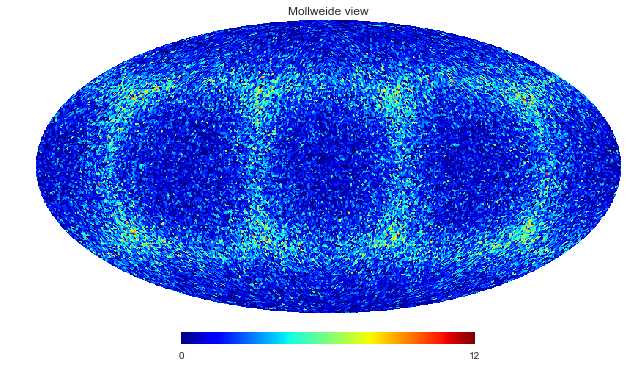

In [10]:
# Retreive count-map (how many object each pixel contains)
hp.mollview(np.array(pixelized_object_container.get_countmap()))

-------
# IO
- PySource: Load data from file
- PySink: Write data to file
- PyFilter: Apply Filter to data
- PyFilterStream: Connect Source->Filter(s)->Sink

## PyFilter
- tophat
- gauss
- generic (specify window function r->p, where p is the acceptance probability at distance r (in [0,1])
- AngMask

In [11]:
# TopHat Filter with radius 100
filt_tophat = CatAna.io.PyFilter("tophat", 100)

In [13]:
# Apply to ObjectContainer
object_container_filt = CatAna.ObjectContainer(python_particles, 'cartesian')
filt_tophat(object_container_filt)

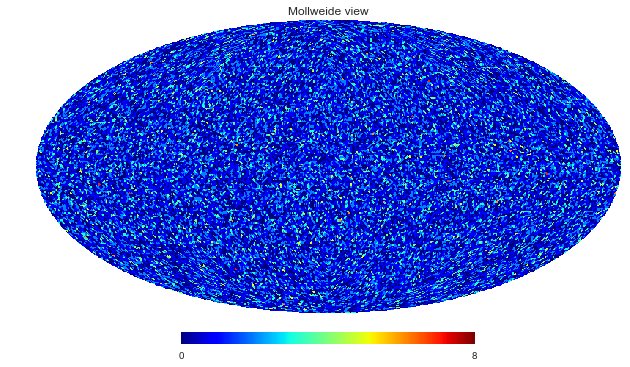

In [14]:
hp.mollview(np.array(CatAna.PixelizedObjectContainer(64, object_container_filt).get_countmap()))

In [15]:
#AngMask
mask = np.zeros(12)
mask[3] = 1
filt_mask = CatAna.io.PyFilter("AngMask", mask)

        Use :meth:`BinTableHDU.from_columns` for new BINARY tables or :meth:`TableHDU.from_columns` for new ASCII tables instead. [astropy.utils.decorators]


In [16]:
# Apply to ObjectContainer
filt_mask(object_container_filt)

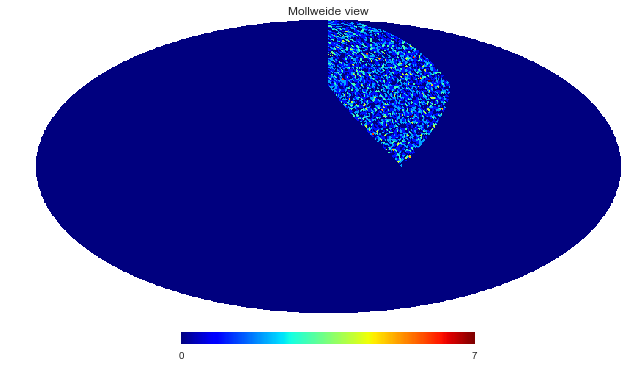

In [17]:
hp.mollview(np.array(CatAna.PixelizedObjectContainer(64, object_container_filt).get_countmap()))

## PySource
Supported Formats
- Text: Set  coord = 'cartesian' | 'spherical' | 'spherical_3dex'
- Gadget

## PySink
Supported Formats
- Text: Set  coord = 'cartesian' | 'spherical' | 'spherical_3dex'

## PyFilterStream

-------
# DECOMP : SFB decomposition
The decomposition can either be directly done from ObjectContainers (brute-force) or PixelizedObjectContainers (fast).
There is also a PyAnalyzer class for convenience to directly process PySource sources with Filters without the need to first load the data into ObjectContainers.

In [19]:
lmax = 5; nmax = 20; rmax=100; window_volume = 4/3.*np.pi * 100**3 
filt_tophat(object_container)

## Raw (brute-force) decomposition from ObjectContainer

In [20]:
kclkk = CatAna.decomp.sfb_decomposition(object_container, lmax, nmax, rmax, window_volume, store_flmn = True)

In [21]:
k_ln = np.array(kclkk.k_ln)
c_ln = np.array(kclkk.c_ln)
f_2mn = np.array(kclkk.f_lmn[2])  # The f_lmn components for l=2

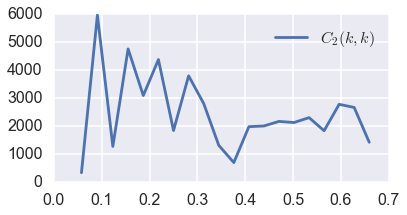

In [25]:
l=2
fig,ax = plt.subplots(1,1,figsize=(6,3))
ax.plot(k_ln[l], c_ln[l], label=r'$C_{}(k,k)$'.format(l))
ax.legend();

## Fast decomposition from PixelizedObjectContainer

In [26]:
pix_oc = CatAna.PixelizedObjectContainer(128, object_container)
kclkk = CatAna.decomp.sfb_decomposition(pix_oc, lmax, nmax, rmax, window_volume, store_flmn = True)

In [27]:
k_ln = np.array(kclkk.k_ln)
c_ln = np.array(kclkk.c_ln)
f_2mn = np.array(kclkk.f_lmn[2])  # The f_lmn components for l=2

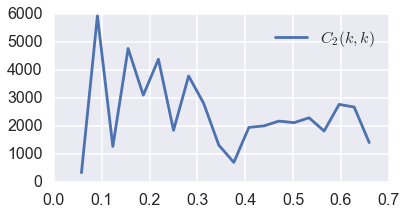

In [28]:
l=2
fig,ax = plt.subplots(1,1,figsize=(6,3))
ax.plot(k_ln[l], c_ln[l], label=r'$C_{}(k,k)$'.format(l))
ax.legend();

## Directly load from PySource: PyAnalyzer